In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.datasets as datasets
import torchvision.utils as vutils

import numpy as np
import csv
import pandas as pd
import numpy as np
# import cv2
import glob
import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import torchvision
from torchvision.io import read_image
from IPython.display import HTML

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [3]:
# !unzip /content/drive/MyDrive/thesis/CASIA-WebFace.zip

# !gdown --id 1Of_EVz-yHV7QVWQGihYfvtny9Ne8qXVz -O CASIA-WebFace.zip
# !unzip /content/CASIA-WebFace.zip
# !rm /content/CASIA-WebFace.zip

In [3]:
data = []

labels_paths = glob.glob('/home/sharifullina/thesis/datasets/CASIA-WebFace/' + '*')
n_labels = len(labels_paths)

for i in range(n_labels):
    for j in range(len(glob.glob(labels_paths[i] + '/*.jpg'))):
        data.append([glob.glob(labels_paths[i] + '/*.jpg')[j], labels_paths[i].split('/')[-1]])


In [4]:
sample_data = data[:10000]

with open('/home/sharifullina/thesis/data/cGAN_100epochs_10000images.csv', 'w') as sample_f:
    writer = csv.writer(sample_f)
    writer.writerow(['image', 'label'])
    writer.writerows(sample_data)

# dataset

In [8]:
class CasiaDataset(Dataset):
    def __init__(self,
                 imgs_path,
                 csv_file,
                 transform
                ):
        self.imgs_path = imgs_path
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        self.data = self.data.sample(frac=1)
        image = Image.open(self.data.iloc[index, 0])

        if self.transform:
            image = self.transform(image)

        return image

In [9]:
transform = transforms.Compose([
                                transforms.CenterCrop((128, 128)), 
                                transforms.Grayscale(),
                                transforms.ToTensor()
                                ])

sample_dataset = CasiaDataset(imgs_path = '/home/sharifullina/thesis/dataset/CASIA-WebFace',
                          csv_file = '/home/sharifullina/thesis/data/cGAN_100epochs_10000images.csv',
                          transform = transform)

sample_loader = DataLoader(sample_dataset, 
                    batch_size=64,
                    )

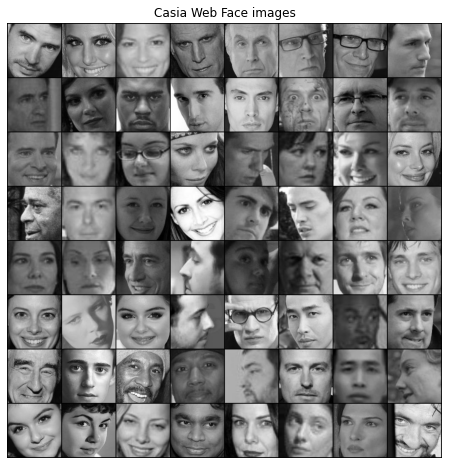

In [10]:
real_batch = next(iter(sample_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Casia Web Face images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device), padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [12]:
%load_ext tensorboard
from torch.utils.tensorboard import SummaryWriter

In [28]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super(Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect")
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )

        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.down = down

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x


class Generator1(nn.Module):
    def __init__(self, in_channels=1, features=32):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        self.down1 = Block(features, features * 2, down=True, act="leaky", use_dropout=False)
        self.down2 = Block(
            features * 2, features * 4, down=True, act="leaky", use_dropout=False
        )
        self.down3 = Block(
            features * 4, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down4 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down5 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down6 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features * 8, features * 8, 4, 2, 1), nn.ReLU()
        )

        self.up1 = Block(features * 8, features * 8, down=False, act="relu", use_dropout=True)
        self.up2 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up3 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up4 = Block(
            features * 8 * 2, features * 4, down=False, act="relu", use_dropout=False
        )
        self.up5 = Block(
            features * 8, features * 2, down=False, act="relu", use_dropout=False
        )
        self.up6 = Block(
            features * 4 , features, down=False, act="relu", use_dropout=False
        )
        self.up7 = Block(features * 2 * 2, features, down=False, act="relu", use_dropout=False)
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features * 2, in_channels, kernel_size=4, stride=2, padding=1),
            # nn.Tanh(),
            nn.Sigmoid()
        )

    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        bottleneck = self.bottleneck(d6)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d6], 1))
        up3 = self.up3(torch.cat([up2, d5], 1))
        up4 = self.up4(torch.cat([up3, d4], 1))
        up5 = self.up5(torch.cat([up4, d3], 1))
        up6 = self.up6(torch.cat([up5, d2], 1))
        return self.final_up(torch.cat([up6, d1], 1))

In [29]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(CNNBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, 4, stride, 1, bias=False, padding_mode="reflect"
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.conv(x)


class Discriminator1(nn.Module):
    def __init__(self, in_channels=1, features=[32, 64, 128, 256]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels ,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                CNNBlock(in_channels, feature, stride=1 if feature == features[-1] else 2),
            )
            in_channels = feature

        layers.append(
            nn.Conv2d(
                in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"
            ),
        )
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # x = torch.cat([x, y], dim=1)
        x = self.initial(x)
        x = self.model(x)
        return x


# training model

In [30]:
lr = 3e-4
batch_size = 64
num_epochs = 100
n_noise = 256
n_critic = 1


In [31]:
discriminator = Discriminator1().to(device)
generator = Generator1().to(device)

criterion_gan = nn.BCELoss()
D_opt = torch.optim.Adam(discriminator.parameters(), lr = lr)
G_opt = torch.optim.Adam(generator.parameters(), lr = lr)
fixed_noise = torch.randn((batch_size, 1, 128, 128)).to(device)

In [13]:
writer_fake = SummaryWriter(f"/home/sharifullina/thesis/logs_cGAN_25epochs_100000images/fake")
writer_real = SummaryWriter(f"/home/sharifullina/thesis/logs_cGAN_25epochs_100000images/real")

In [33]:
G_losses = []
D_losses = []
img_list = []

In [45]:
generator.train()
discriminator.train()

for epoch in range(num_epochs):
    for idx, images in enumerate(sample_loader, 0):
    
        step = 0
        real_imgs = images.to(device)
        batch_size = real_imgs.size(0)
        noise = torch.randn(real_imgs.size(0), 1, 128, 128, device=device)

        D_opt.zero_grad()
        G_opt.zero_grad()

        fake = generator(noise)
        disc_real = discriminator(real_imgs)
        D_loss_1 = criterion_gan(disc_real, torch.ones_like(disc_real))
        disc_fake = discriminator(fake)
        D_loss_2 = criterion_gan(disc_fake, torch.zeros_like(disc_fake))
        D_loss = (D_loss_1 + D_loss_2) / 2
        D_opt.zero_grad()
        D_loss.backward(retain_graph=True)
        D_opt.step()

        output = discriminator(fake)
        G_loss = criterion_gan(output, torch.ones_like(output))
        G_opt.zero_grad()
        G_loss.backward()
        G_opt.step()

        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())

        if idx % 100 == 0:
              print(f"Epoch [{epoch}/{num_epochs}] Batch {idx}/{len(sample_loader)} \
              Loss D: {D_loss:.4f}, loss G: {G_loss:.4f}")

        if idx % 100 == 0:
            with torch.no_grad():
                fake = generator(fixed_noise)
                data = real_imgs
                img_grid_real = torchvision.utils.make_grid(data, normalize = True)
                img_grid_fake = torchvision.utils.make_grid(fake, normalize = True)
                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)
            step += 1

Epoch [0/25] Batch 0/157               Loss D: 0.1814, loss G: 4.2537
Epoch [0/25] Batch 100/157               Loss D: 0.1626, loss G: 3.4426
Epoch [1/25] Batch 0/157               Loss D: 0.1325, loss G: 4.4136
Epoch [1/25] Batch 100/157               Loss D: 0.3185, loss G: 3.9780
Epoch [2/25] Batch 0/157               Loss D: 0.4267, loss G: 3.7800
Epoch [2/25] Batch 100/157               Loss D: 0.6925, loss G: 2.5709
Epoch [3/25] Batch 0/157               Loss D: 0.1405, loss G: 3.9470
Epoch [3/25] Batch 100/157               Loss D: 0.2929, loss G: 2.9214
Epoch [4/25] Batch 0/157               Loss D: 0.0858, loss G: 5.5732
Epoch [4/25] Batch 100/157               Loss D: 0.1280, loss G: 3.8178
Epoch [5/25] Batch 0/157               Loss D: 0.2999, loss G: 2.6049
Epoch [5/25] Batch 100/157               Loss D: 0.4428, loss G: 1.9670
Epoch [6/25] Batch 0/157               Loss D: 0.0853, loss G: 5.1216
Epoch [6/25] Batch 100/157               Loss D: 0.2322, loss G: 2.6151
Epoch 

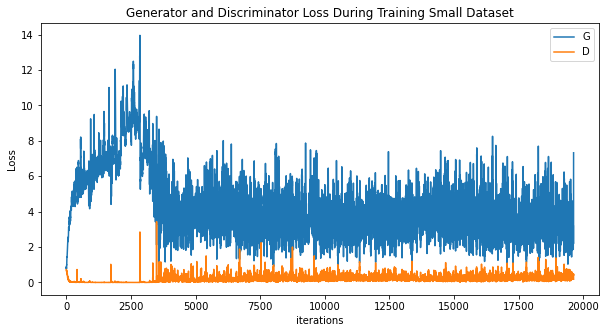

In [46]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training Small Dataset")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('/home/sharifullina/thesis/losses/loss_cGAN_100epochs_10000images.png')
plt.show()

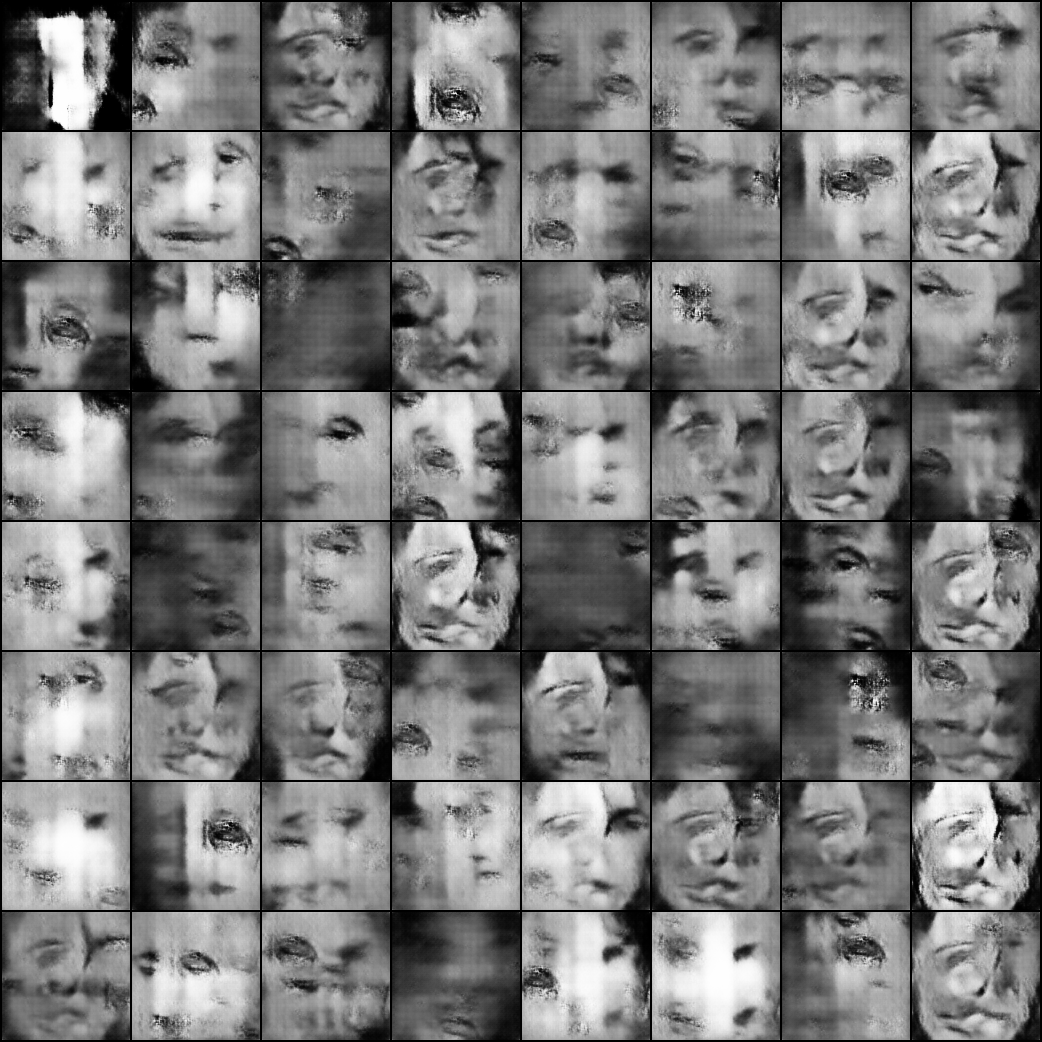

In [48]:
from IPython.display import display, Image
display(Image(filename='/home/sharifullina/tmp/fake_images/cGAN_small_images_epochs100.png'))

In [47]:
tensorboard --logdir logs_small_dataset --port=6666

Reusing TensorBoard on port 6666 (pid 8129), started 1:04:56 ago. (Use '!kill 8129' to kill it.)

---